# Descarga de catálogos e imágenes

**Autor:** Roberto Muñoz <br>
**Github:** <https://github.com/rpmunoz>

Este notebook muestra cómo descargar imágenes y catálogos de galaxias desde los servidores del Sloan Digital Sky Survey (SDSS). El SDSS es un survey astronómico que partió el año 1998 y que durante 15 años mapeó gran parte del cielo del hemisferio norte. El catálogo generado por el SDSS contiene información de cerca de 500 millones de estrellas y galaxias.

Este notebook se apoya en el uso de librerías estándar de Python y otras creadas por la comunidad de Astronomía.

- numpy
- pandas
- matplotlib
- astropy
- astroquery

### Partimos instalando las librerías astronómicas astropy y astroquery

In [1]:
!pip install astropy
!pip install astroquery

### Cagamos las librerías que usaremos para leer los catálogos locales y hacer consultas a los catálogos remotos del SDSS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astroquery.sdss import SDSS

from sdss_tools import sdss_jpg, sdss_fits

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings("ignore", category=AstropyWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
#warnings.simplefilter('ignore', UserWarning)

### Caragamos el catalogo local de galaxias de GalaxyZoo

[GalaxyZoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) es un proyecto de ciencia ciudadana que invita a la comunidad a examinar imágenes de galaxias y clasificarlas morfológicamente. Usaremos un catálogo local en formato csv que fue descargado desde https://data.galaxyzoo.org/.

In [3]:
catFile = 'data/GalaxyZoo1_DR_table2.csv'
catDF = pd.read_csv(catFile)
catDF.head()

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
0,587727178986356823,00:00:00.41,-10:22:25.7,59,0.610,0.034,0.000,0.153,0.153,0.051,0.186,0.610,0.186,0,0,1
1,587727227300741210,00:00:00.74,-09:13:20.2,18,0.611,0.000,0.167,0.222,0.000,0.000,0.389,0.203,0.797,1,0,0
2,587727225153257596,00:00:01.03,-10:56:48.0,68,0.735,0.029,0.000,0.147,0.074,0.015,0.176,0.432,0.428,0,0,1
3,587730774962536596,00:00:01.38,+15:30:35.3,52,0.885,0.019,0.000,0.058,0.019,0.019,0.077,0.885,0.077,0,1,0
4,587731186203885750,00:00:01.55,-00:05:33.3,59,0.712,0.000,0.000,0.220,0.068,0.000,0.220,0.640,0.290,0,0,1


Este catalogo contiene información morfológica de múltiples galaxias. Cada fila es una galaxia única en el survey del SDSS.

Las principales columnas del catálogo son

- OBJID: Id único de la fuente en el catálogo SDSS
- RA: Ascensión recta de la fuente (HH:mm:ss)
- DEC: Declinación recta de la fuente (DD:mm:ss)
- NVOTE: Número total de votos
- P_EL: Fraccion de votos para clase Eliptica
- P_CW: Fraccion de votos para clase Espiral con brazos direccion clockwise
- P_ACW: Fraccion de votos para clase Espiral con brazos direccion anticlockwise
- P_EDGE: Fraccion de votos para clase galaxia vista de canto (edge)
- P_DK: Fraccion de votos para clase no identificada (Don't know)
- P_MG: Fraccion de votos para clase Merger
- P_CS: Fraccion de votos para clase Espiral combinada (P_CS = P_EL + P_CW + P_ACW)

Crearemos una columna nueva llamada P_S para agrupar la fraccion de votos de las galaxias espirales clockwise y anticlockwise. Esta columna se llamará P_S

In [4]:
catDF['P_S'] = catDF['P_CW'] + catDF['P_ACW']
catDF.head()

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,P_S
0,587727178986356823,00:00:00.41,-10:22:25.7,59,0.610,0.034,0.000,0.153,0.153,0.051,0.186,0.610,0.186,0,0,1,0.034
1,587727227300741210,00:00:00.74,-09:13:20.2,18,0.611,0.000,0.167,0.222,0.000,0.000,0.389,0.203,0.797,1,0,0,0.167
2,587727225153257596,00:00:01.03,-10:56:48.0,68,0.735,0.029,0.000,0.147,0.074,0.015,0.176,0.432,0.428,0,0,1,0.029
3,587730774962536596,00:00:01.38,+15:30:35.3,52,0.885,0.019,0.000,0.058,0.019,0.019,0.077,0.885,0.077,0,1,0,0.019
4,587731186203885750,00:00:01.55,-00:05:33.3,59,0.712,0.000,0.000,0.220,0.068,0.000,0.220,0.640,0.290,0,0,1,0.000


Aplicamos una serie de filtros para crear catálogos separados de galaxias elípticas, espirales, edge y mergers 

In [5]:
ellipticalDF = catDF.query('P_EL >0.5').sort_values('P_EL',ascending=0)
spiralDF = catDF.query('P_S > 0.5').sort_values('P_S',ascending=0)
edgeDF = catDF.query('P_EDGE >0.5').sort_values('P_EDGE',ascending=0)
mergerDF = catDF.query('P_MG >0.5').sort_values('P_MG',ascending=0)

In [6]:
ellipticalDF.head()

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,P_S
116361,588010136266866753,09:13:25.89,+52:58:52.8,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
48718,587725773996228833,08:03:23.09,+45:31:51.9,29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
217170,587742772940570755,10:49:22.48,+15:03:37.3,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
47697,588013382721274340,08:02:12.82,+28:52:23.7,46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
515531,587736914606620894,14:55:13.52,+10:54:25.7,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0


In [7]:
spiralDF.head()

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,P_S
585807,587739407340404910,15:57:58.93,+22:19:30.5,52,0.0,0.981,0.019,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.0
250600,588017703462830232,11:17:54.18,+12:03:15.1,66,0.0,0.015,0.985,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.0
79024,587738067808944242,08:36:31.84,+61:42:42.4,25,0.0,0.000,1.000,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.0
588552,587729228762382424,16:00:38.94,+54:59:00.0,29,0.0,0.000,1.000,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.0
425392,587729159507869872,13:41:05.21,+05:06:20.9,52,0.0,0.000,1.000,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1.0


### Descargamos informacion fotometrica desde SDSS

La librería astroquery permite hacer consultas a los cátálogos del SDSS usando las coordendas de las fuentes de interés. La librería requiere que las coordenadas RA y DEC sean especificadas en grados.

Partimos revisando el tamaño del catalogo spiralDF y eligiendo aleatoriamente 30 galaxias

In [8]:
len(spiralDF)

66015

In [9]:
sampleDF = spiralDF.sample(n=10, random_state=42)
len(sampleDF)

10

In [10]:
sampleDF = sampleDF[['OBJID','RA','DEC']]
sampleDF.head()

,OBJID,RA,DEC
339837,588017728689012856,12:25:43.29,+06:53:24.2
345745,587725039558394010,12:30:38.88,-03:14:05.8
566796,588017604970217667,15:38:56.52,+32:49:25.4
165216,587742013806739661,10:03:17.35,+18:51:56.2
621731,587729653959360743,16:39:26.01,+40:36:09.0


In [11]:
sampleDF['RA'] = Angle(sampleDF['RA'], unit=u.hourangle).degree
sampleDF['DEC'] = Angle(sampleDF['DEC'], unit=u.degree).degree

sampleDF.head()

,OBJID,RA,DEC
339837,588017728689012856,186.430375,6.890056
345745,587725039558394010,187.662000,-3.234944
566796,588017604970217667,234.735500,32.823722
165216,587742013806739661,150.822292,18.865611
621731,587729653959360743,249.858375,40.602500


Ahora podemos hacer un query a los servidores del SDSS

In [20]:
coo=SkyCoord(sampleDF['RA'], sampleDF['DEC'], unit=(u.deg, u.deg))

sdssDF = pd.DataFrame()
for i in range(len(coo)):
    print('Processing galaxy ', i)
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
    print(result)
    
    sdssDF = sdssDF.append(result.to_pandas().loc[0], ignore_index=True)
    
sdssDF = sdssDF.rename(columns = {'z1':'redshift'})
sdssDF = sdssDF[['ra','dec','u','g','r','i','z','redshift']]

Processing galaxy  0
      ra             dec           u     ...    i        z         z1    
-------------- ---------------- -------- ... -------- -------- ----------
186.4303793542 6.89004999573451 19.29072 ... 16.36568 16.09331 0.07654753
Processing galaxy  1
       ra               dec           u     ...    i        z         z1    
---------------- ----------------- -------- ... -------- -------- ----------
187.661985789995 -3.23493622548474 17.69997 ... 15.73655 15.52771 0.04125151
Processing galaxy  2
       ra              dec          u     ...    i        z         z1   
---------------- --------------- -------- ... -------- -------- ---------
234.735494867507 32.823726520028 19.09427 ... 17.11024 16.90405 0.1262884
Processing galaxy  3
       ra              dec           u     ...    i        z         z1   
---------------- ---------------- -------- ... -------- -------- ---------
150.822283599176 18.8656125875296 20.17254 ... 17.09255 16.74145 0.1633165
Processing galax

Imprimimos el número de galaxias que tenemos en el dataframe

In [21]:
print(len(sdssDF))
sdssDF.head()

10


,ra,dec,u,g,r,i,z,redshift
0,186.430379,6.890050,19.29072,17.56456,16.78211,16.36568,16.09331,0.076548
1,187.661986,-3.234936,17.69997,16.47884,16.00701,15.73655,15.52771,0.041252
2,234.735495,32.823727,19.09427,18.02415,17.42668,17.11024,16.90405,0.126288
3,150.822284,18.865613,20.17254,18.65029,17.58645,17.09255,16.74145,0.163317
4,249.858354,40.602508,17.52493,16.38439,15.97529,15.74936,15.57530,0.034727


### Descargamos imágenes JPEG desde SDSS


Procesando galaxia 0
Procesando galaxia 1
Procesando galaxia 2
Procesando galaxia 3
Procesando galaxia 4
Procesando galaxia 5
Procesando galaxia 6
Procesando galaxia 7
Procesando galaxia 8
Procesando galaxia 9


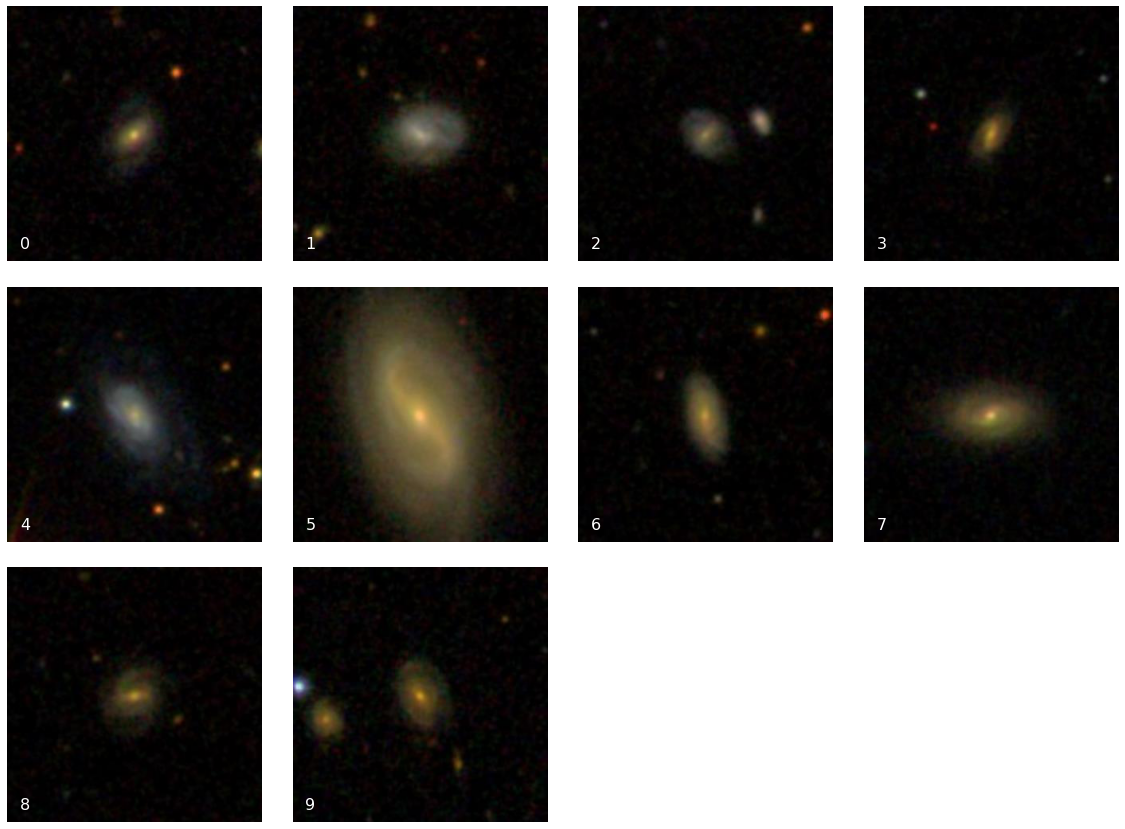

In [16]:
sdss_jpg(coo)